In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [29]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,precision_recall_curve,classification_report
from keras.applications import InceptionV3
from keras.layers import Conv2D,Dense, GlobalAveragePooling2D,MaxPooling2D,Flatten,Dropout
from keras.models import Model , Sequential
from keras.optimizers import SGD,Adam,RMSprop
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[]

In [4]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_visible_devices(gpus, 'GPU')

In [15]:
train_img='/kaggle/input/ham10000-googlenet/HAM10000_images'
data=pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv",usecols=['image_id','dx'])

In [16]:
data.head(5)

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl


In [17]:
data.describe()

,image_id,dx
count,10015,10015
unique,10015,7
top,ISIC_0027419,nv
freq,1,6705


In [18]:
df=pd.DataFrame()

# reading taking only 100 images belonging to each class
labels=data['dx'].unique()
for label in labels:
  label_df=data[data['dx']==label]
  label_df=label_df.sample(500,random_state=42,replace=True)
  df=pd.concat([df,label_df])
df=df.sample(frac=1,random_state=42)

df.describe()

,image_id,dx
count,3500,3500
unique,2098,7
top,ISIC_0031443,mel
freq,12,500


In [19]:
df['image_path']=df['image_id'].apply(lambda x: os.path.join(train_img,x+'.jpg'))
df=df.drop('image_id',axis=1)
df.head(3)

,dx,image_path
1430,mel,/kaggle/input/ham10000-googlenet/HAM10000_imag...
2452,vasc,/kaggle/input/ham10000-googlenet/HAM10000_imag...
2341,vasc,/kaggle/input/ham10000-googlenet/HAM10000_imag...


In [21]:
df['image']=df['image_path'].apply(lambda x: cv2.imread(x))
df['image']=df['image'].apply(lambda x: np.array(cv2.resize(x,(227,227))))
df['image']=df['image']/255
df.head()

,dx,image_path,image
1430,mel,/kaggle/input/ham10000-googlenet/HAM10000_imag...,"[[[0.5882352941176471, 0.6470588235294118, 0.8..."
2452,vasc,/kaggle/input/ham10000-googlenet/HAM10000_imag...,"[[[0.6784313725490196, 0.5882352941176471, 0.9..."
2341,vasc,/kaggle/input/ham10000-googlenet/HAM10000_imag...,"[[[0.7294117647058823, 0.6705882352941176, 0.7..."
2145,mel,/kaggle/input/ham10000-googlenet/HAM10000_imag...,"[[[0.6470588235294118, 0.5803921568627451, 0.7..."
877,bkl,/kaggle/input/ham10000-googlenet/HAM10000_imag...,"[[[0.20392156862745098, 0.1803921568627451, 0...."


In [22]:
le=LabelEncoder()
df['encoded_dx']=le.fit_transform(df['dx'])
df['encoded_dx'].value_counts()

encoded_dx
4    500
6    500
2    500
3    500
1    500
0    500
5    500
Name: count, dtype: int64

In [23]:
y=to_categorical(df['encoded_dx'])

In [24]:
x=np.array(df['image'].tolist())

In [25]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [26]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [30]:
#Alexnet
def create_alexnet(num_classes):
    model = Sequential()

    model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(227, 227, 3)))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))

    model.add(Conv2D(256, (5, 5), activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))

    model.add(Conv2D(384, (3, 3), activation='relu'))

    model.add(Conv2D(384, (3, 3), activation='relu'))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model


num_classes = 7
alexnet_model = create_alexnet(num_classes)

In [31]:
alexnet_model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])


In [32]:
alexnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 384)         1

In [34]:
batch_size = 28
epochs = 20

history = alexnet_model.fit(x_train, y_train,  # Use y_train_encoded
                            batch_size=batch_size, epochs=epochs,
                            validation_data=(x_test, y_test))  # Use y_test_encoded

Epoch 1/20
100/100 [==============================] - 139s 1s/step - loss: 1.8959 - accuracy: 0.1882 - val_loss: 1.7997 - val_accuracy: 0.2571
Epoch 2/20
100/100 [==============================] - 136s 1s/step - loss: 1.7437 - accuracy: 0.2671 - val_loss: 1.6494 - val_accuracy: 0.3171
Epoch 3/20
100/100 [==============================] - 136s 1s/step - loss: 1.5781 - accuracy: 0.3575 - val_loss: 1.5789 - val_accuracy: 0.3486
Epoch 4/20
100/100 [==============================] - 135s 1s/step - loss: 1.4708 - accuracy: 0.3700 - val_loss: 1.4749 - val_accuracy: 0.3814
Epoch 5/20
100/100 [==============================] - 136s 1s/step - loss: 1.4068 - accuracy: 0.4150 - val_loss: 1.4851 - val_accuracy: 0.3814
Epoch 6/20
100/100 [==============================] - 136s 1s/step - loss: 1.3541 - accuracy: 0.4525 - val_loss: 1.3777 - val_accuracy: 0.4414
Epoch 7/20
100/100 [==============================] - 136s 1s/step - loss: 1.3235 - accuracy: 0.4561 - val_loss: 1.3250 - val_accuracy: 0.4600

In [35]:
# model evaluation
test_loss, test_accuracy = alexnet_model.evaluate(x_test,y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
y_pred = alexnet_model.predict(x_test)

22/22 [==============================] - 8s 360ms/step - loss: 0.8302 - accuracy: 0.7057
Test Loss: 0.8302, Test Accuracy: 0.7057
22/22 [==============================] - 9s 416ms/step


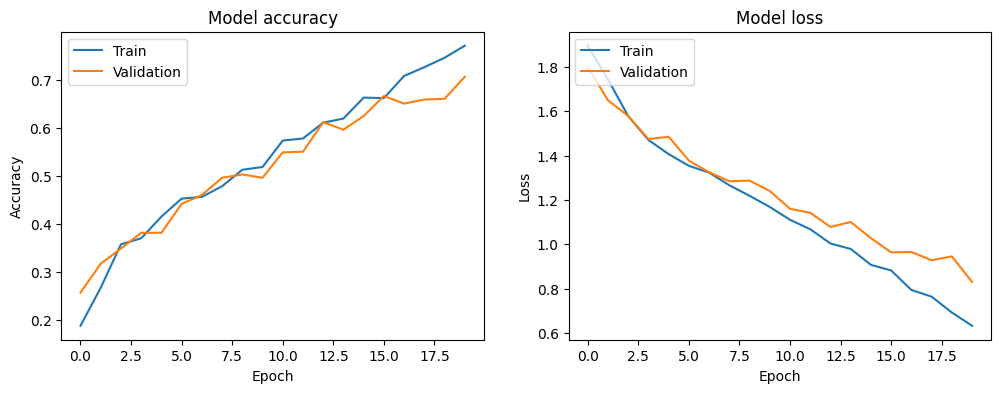

In [36]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [37]:
# Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [38]:

# Generate a classification report
classification_rep = classification_report(y_true, y_pred, target_names=le.classes_)



In [40]:
# Print the classification report
print("Classification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

       akiec       0.60      0.77      0.67       111
         bcc       0.63      0.48      0.55        94
         bkl       0.73      0.43      0.54       101
          df       0.87      0.94      0.91       103
         mel       0.52      0.77      0.62       100
          nv       0.75      0.60      0.67       102
        vasc       0.97      0.97      0.97        89

    accuracy                           0.71       700
   macro avg       0.73      0.71      0.70       700
weighted avg       0.72      0.71      0.70       700

